In [1]:
import nilearn
from nilearn.image import resample_img
import nibabel as nib
from templateflow import api
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting

from scipy.signal import savgol_filter

In [50]:
subject_idx = 4

In [51]:
## get functional data
path_to_data = f"/Users/jacekdmochowski/PROJECTS/fus/data/fmriprep_out/sub-{subject_idx:02d}/func"
path_to_anat = f"/Users/jacekdmochowski/PROJECTS/fus/data/fmriprep_out/sub-{subject_idx:02d}/anat"

anat_filename = f"sub-{subject_idx:02d}_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"
bold_filename = f"sub-{subject_idx:02d}_task-prefuspost_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
mask_filename = f"sub-{subject_idx:02d}_task-prefuspost_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"

anat = nib.load(os.path.join(path_to_anat, anat_filename))
bold = nib.load(os.path.join(path_to_data, bold_filename))
mask = nib.load(os.path.join(path_to_data, mask_filename))

# 77 = number of voxels left to right
# 95 = number of voxels anterior to posterior
# 82 = number of voxels inferior to superior
# 900 = number of time points
bold.get_fdata().shape, anat.get_fdata().shape, mask.get_fdata().shape

((77, 95, 82, 900), (241, 286, 241), (77, 95, 82))

In [52]:
## get atlas
path = api.get('MNI152NLin2009cAsym', atlas="Schaefer2018", desc="200Parcels17Networks", resolution=2, suffix="dseg", extension="nii.gz")

atlas = nib.load(path)
target_affine = atlas.affine
target_shape = np.array(atlas.dataobj).shape

# get the atlas labels
atlas_labels = np.unique(np.array(atlas.dataobj))

In [53]:
# because the atlas has a different shape, we need to resample the mask and bold data
resampled_mask = resample_img(mask, target_affine=target_affine, target_shape=target_shape[0:3], interpolation='nearest')
resampled_bold = resample_img(bold, target_affine=target_affine, target_shape=target_shape[0:3])

In [54]:
# pickle the resampled data

# TODO: check if pickled data exists, if so, skip this step; if not, load it here instead of running the cell above

resampled_bold.to_filename(f'/Users/jacekdmochowski/PROJECTS/fus/data/fmriprep_out/sub-{subject_idx:02d}/func/sub-{subject_idx:02d}_task-prefuspost_space-MNI152NLin2009cAsym_desc-preproc_bold_resampled.nii.gz')
resampled_mask.to_filename(f'/Users/jacekdmochowski/PROJECTS/fus/data/fmriprep_out/sub-{subject_idx:02d}/func/sub-{subject_idx:02d}_task-prefuspost_space-MNI152NLin2009cAsym_desc-brain_mask_resampled.nii.gz')

In [55]:
# get the mean and std for each section of the experiment
mu_bsl = np.mean(resampled_bold.get_fdata()[:,:,:,0:300], axis=-1) # mean across time before stimulation at each voxel
mu_fus = np.mean(resampled_bold.get_fdata()[:,:,:,300:600], axis=-1)
mu_rec = np.mean(resampled_bold.get_fdata()[:,:,:,600:900], axis=-1)

sigma_bsl = np.std(resampled_bold.get_fdata()[:,:,:,0:300], axis=-1)
sigma_fus = np.std(resampled_bold.get_fdata()[:,:,:,300:600], axis=-1)
sigma_rec = np.std(resampled_bold.get_fdata()[:,:,:,600:900], axis=-1)

In [56]:
# mask out the non-brain voxels
is_outside_brain = resampled_mask.get_fdata() == 0

mu_bsl[is_outside_brain] = np.nan
mu_fus[is_outside_brain] = np.nan
mu_rec[is_outside_brain] = np.nan

sigma_bsl[is_outside_brain] = np.nan
sigma_fus[is_outside_brain] = np.nan
sigma_rec[is_outside_brain] = np.nan

In [57]:
mu_bsl.shape

(97, 115, 97)

In [58]:
# Z differences
z_fus = (mu_fus-mu_bsl)/(0.5*sigma_fus + 0.5*sigma_bsl)
z_rec = (mu_rec-mu_bsl)/(0.5*sigma_rec + 0.5*sigma_bsl)
z_rec_fus = (mu_rec-mu_fus)/(0.5*sigma_rec + 0.5*sigma_fus)
print("bsl to fus", np.nanmin(z_fus), np.nanmax(z_fus))
print("bsl to rec", np.nanmin(z_rec), np.nanmax(z_rec))
print("fus to rec", np.nanmin(z_rec_fus), np.nanmax(z_rec_fus))

bsl to fus -3.282056288791098 3.717135777713709
bsl to rec -5.033232715419877 5.940626270486002
fus to rec -3.3426274439350037 3.6285374032234445


/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_82290/4024269759.py:2: RuntimeWarning: invalid value encountered in divide
  z_fus = (mu_fus-mu_bsl)/(0.5*sigma_fus + 0.5*sigma_bsl)
/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_82290/4024269759.py:3: RuntimeWarning: invalid value encountered in divide
  z_rec = (mu_rec-mu_bsl)/(0.5*sigma_rec + 0.5*sigma_bsl)
/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_82290/4024269759.py:4: RuntimeWarning: invalid value encountered in divide
  z_rec_fus = (mu_rec-mu_fus)/(0.5*sigma_rec + 0.5*sigma_fus)


In [59]:
# sigmas only
z_fus = (sigma_fus - sigma_bsl)/sigma_bsl
z_rec = (sigma_rec - sigma_bsl)/sigma_bsl
print("bsl to fus", np.nanmin(z_fus), np.nanmax(z_fus))
print("bsl to rec", np.nanmin(z_rec), np.nanmax(z_rec))

# plot the histogram but ignore the nans
#plt.hist(z_fus[~np.isnan(z_fus)].flatten(), bins=100, alpha=0.5, label='fus')

bsl to fus -1.0 3.2490911627401604
bsl to rec -1.0 inf


/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_82290/2399697826.py:2: RuntimeWarning: invalid value encountered in divide
  z_fus = (sigma_fus - sigma_bsl)/sigma_bsl
/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_82290/2399697826.py:3: RuntimeWarning: divide by zero encountered in divide
  z_rec = (sigma_rec - sigma_bsl)/sigma_bsl
/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_82290/2399697826.py:3: RuntimeWarning: invalid value encountered in divide
  z_rec = (sigma_rec - sigma_bsl)/sigma_bsl


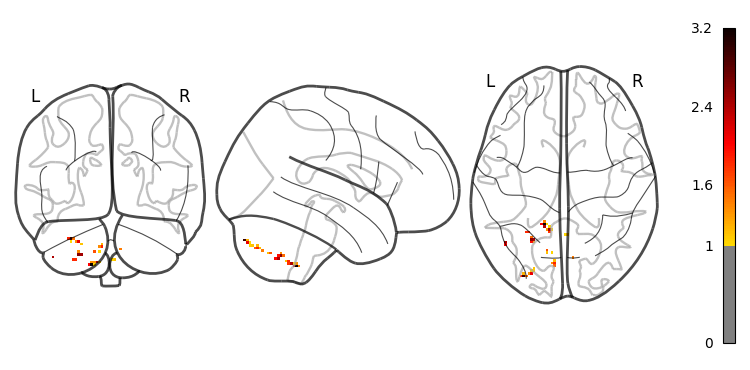

In [64]:
threshold = 1.
stat_img_z_fus = nib.Nifti1Image(z_fus, target_affine)
nilearn.plotting.plot_glass_brain(stat_img_z_fus, threshold=threshold, colorbar=True)

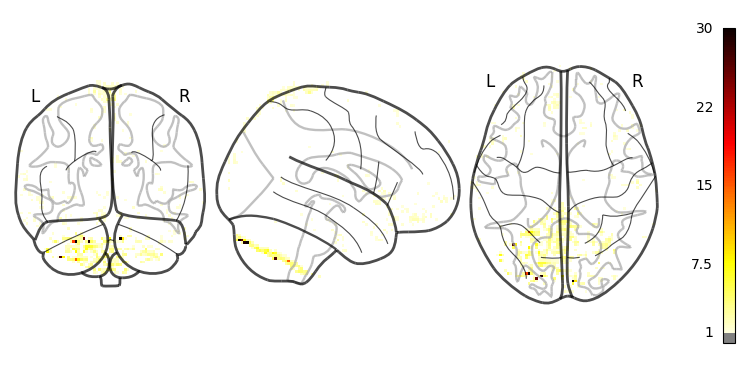

In [65]:
stat_img_z_rec = nib.Nifti1Image(z_rec, target_affine)
nilearn.plotting.plot_glass_brain(stat_img_z_rec, threshold=threshold, colorbar=True)

In [33]:
# identify the voxels above threshold
#stat_img_z.shape, np.sum(stat_img_z.get_fdata()>threshold), resampled_bold.shape

resampled_bold_above_threshold = resampled_bold.get_fdata().copy()
resampled_bold_above_threshold[stat_img_z_fus.get_fdata()<=threshold] = np.nan
resampled_bold_above_threshold = nib.Nifti1Image(resampled_bold_above_threshold, target_affine)

In [34]:
# take the mean across the first three dimensions combined
tmp = np.nanmean(resampled_bold_above_threshold.get_fdata(), axis=(0,1,2))

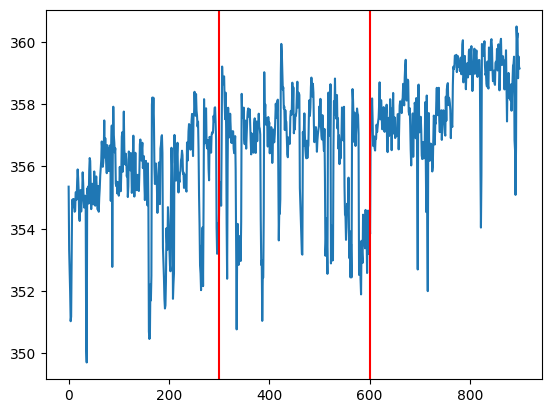

In [35]:
plt.plot(tmp)
# add vertical line at 300 and 600
plt.axvline(300, color='r')
plt.axvline(600, color='r')

bsl to fus -105.72416642520366 34.68508454932868
bsl to rec -167.11145934178876 77.10481840461182


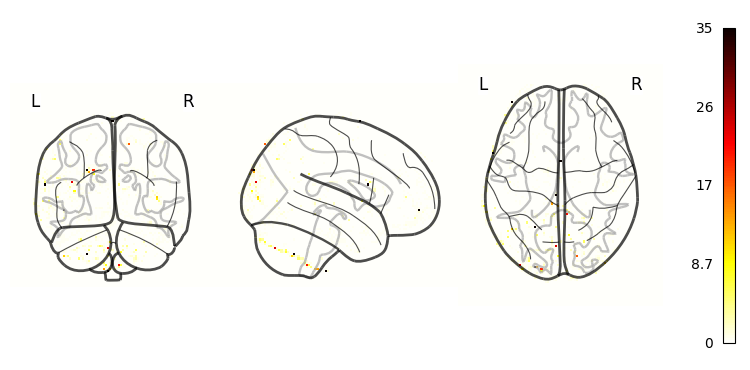

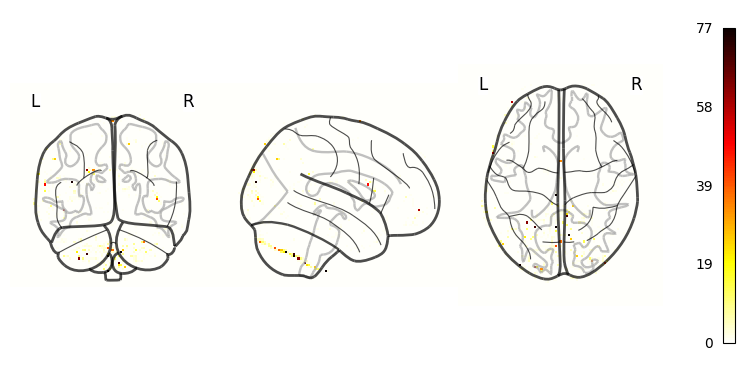

In [64]:
# means only
z_fus = (mu_fus - mu_bsl) / mu_bsl
z_rec = (mu_rec - mu_bsl) / mu_bsl
print("bsl to fus", np.nanmin(z_fus), np.nanmax(z_fus))
print("bsl to rec", np.nanmin(z_rec), np.nanmax(z_rec))

stat_img_z = nib.Nifti1Image(z_fus, target_affine)
nilearn.plotting.plot_glass_brain(stat_img_z, threshold=None, colorbar=True)

stat_img_z = nib.Nifti1Image(z_rec, target_affine)
nilearn.plotting.plot_glass_brain(stat_img_z, threshold=None, colorbar=True)

In [ ]:
#stat_img_z = nib.Nifti1Image(z, target_affine)
#nilearn.plotting.plot_glass_brain(stat_img_z, threshold=1.5)

In [66]:
## compute the power spectrum of the time series
from scipy.signal import welch
TR=1
f, Pxx_bsl = welch(resampled_bold.get_fdata()[:,:,:,0:300], fs=1/TR, axis=-1)
_, Pxx_fus = welch(resampled_bold.get_fdata()[:,:,:,300:600], fs=1/TR, axis=-1)
_, Pxx_rec = welch(resampled_bold.get_fdata()[:,:,:,600:900], fs=1/TR, axis=-1)

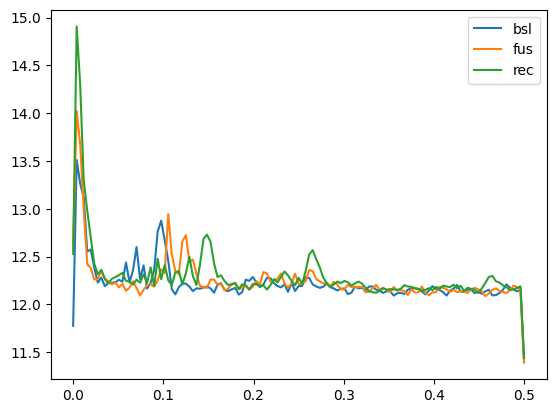

In [69]:
#roi = [66] # LH ACC
#roi = [170] # RH ACC
roi = [50, 80, 81, 82] # LH mPFC
is_in_roi = np.isin(atlas.get_fdata(), roi)
#is_in_roi = atlas.get_fdata() == roi

#is_in_roi = stat_img_z_fus.get_fdata() > threshold

Pxx_bsl_roi = Pxx_bsl[is_in_roi]
Pxx_fus_roi = Pxx_fus[is_in_roi]
Pxx_rec_roi = Pxx_rec[is_in_roi]

plt.plot(f, np.log(Pxx_bsl_roi.mean(axis=0)), label='bsl')
plt.plot(f, np.log(Pxx_fus_roi.mean(axis=0)), label='fus')
plt.plot(f, np.log(Pxx_rec_roi.mean(axis=0)), label='rec')
plt.legend()

(3199, 900)

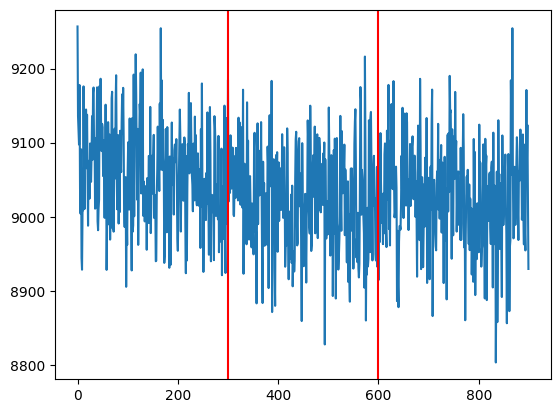

In [73]:
roi = [66] # LH ACC
#roi = [50, 80, 81, 82] # LH mPFC
is_in_roi = np.isin(atlas.get_fdata(), roi)

resampled_bold_roi = resampled_bold.get_fdata()[is_in_roi]
# plot the time series
plt.plot(resampled_bold_roi.mean(axis=0))
plt.axvline(300, color='r')
plt.axvline(600, color='r')